In [1]:
import pandas as pd
import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from copy import deepcopy

In [2]:
df_0 = pd.read_csv('contango_runs_usd.csv', index_col=0, header=[0,1,2])
#df.columns.names = ['run_name', 'feature', 'pool']
df_0

2024-04-12_2024-01-13_[1]_3_1d_1d_0.05_0.05_0.0005_1_1000000.0  \
                                                                                 weights   
                                                              Ethereum_morpho-blue_SPDAI   
2024-01-13 00:00:00+00:00                                           0.000000               
2024-01-14 00:00:00+00:00                                           0.000000               
2024-01-15 00:00:00+00:00                                           0.000000               
2024-01-16 00:00:00+00:00                                           0.000000               
2024-01-17 00:00:00+00:00                                           0.000000               
...                                                                      ...               
2024-04-08 00:00:00+00:00                                       50833.347589               
2024-04-09 00:00:00+00:00                                       50857.814849               
2024-04-10 00:00:00+00:00                                       50915.817057               
2024-04-11 00:00:00+00:00                                       50956.214980               
2024-04-12 00:00:00+00:00                                       51018.663353               

                                                             \
                                                              
                          Ethereum_morpho-blue_USDE-DAI_86%   
2024-01-13 00:00:00+00:00                          0.000000   
2024-01-14 00:00:00+00:00                          0.000000   
2024-01-15 00:00:00+00:00                          0.000000   
2024-01-16 00:00:00+00:00                          0.000000   
2024-01-17 00:00:00+00:00                          0.000000   
...                                                     ...   
2024-04-08 00:00:00+00:00                      50865.322385   
2024-04-09 00:00:00+00:00                      50885.122423   
2024-04-10 00:00:00+00:00                      50938.915943   
2024-04-11 00:00:00+00:00                      50968.148742   
2024-04-12 00:00:00+00:00                      51051.537392   

                                                               \
                                                                
                          Ethereum_morpho-blue_USDE-DAI_91.5%   
2024-01-13 00:00:00+00:00                            0.000000   
2024-01-14 00:00:00+00:00                            0.000000   
2024-01-15 00:00:00+00:00                            0.000000   
2024-01-16 00:00:00+00:00                            0.000000   
2024-01-17 00:00:00+00:00                            0.000000   
...                                                       ...   
2024-04-08 00:00:00+00:00                        50873.460777   
2024-04-09 00:00:00+00:00                        50857.213218   
2024-04-10 00:00:00+00:00                        50960.845435   
2024-04-11 00:00:00+00:00                        51013.057504   
2024-04-12 00:00:00+00:00                        51093.086829   

                                                                \
                                                                 
                          Ethereum_morpho-blue_SUSDE-DAI_91.5%   
2024-01-13 00:00:00+00:00                             0.000000   
2024-01-14 00:00:00+00:00                             0.000000   
2024-01-15 00:00:00+00:00                             0.000000   
2024-01-16 00:00:00+00:00                             0.000000   
2024-01-17 00:00:00+00:00                             0.000000   
...                                                        ...   
2024-04-08 00:00:00+00:00                         50757.449922   
2024-04-09 00:00:00+00:00                         50786.255580   
2024-04-10 00:00:00+00:00                         50836.069227   
2024-04-11 00:00:00+00:00                         50858.198514   
2024-04-12 00:00:00+00:00                         50880.842865   

                  

In [3]:
keys = ['backtest.end_date', 'backtest.start_date', 'label_map.apy.horizons', 'run_parameters.models.apy.TrivialEwmPredictor.params.cap', 'run_parameters.models.apy.TrivialEwmPredictor.params.halflife', 'run_parameters.models.apy.TrivialEwmPredictor.params.horizon', 'strategy.base_buffer', 'strategy.concentration_limit', 'strategy.cost', 'strategy.gas', 'strategy.initial_wealth']
scatters = {}
df = deepcopy(df_0)
for run_name in df.columns.get_level_values(0).unique():
    for horizon in [1, 5, 10, 30]: 
        params = dict(zip(keys, run_name.split('_')))
        halflife = params['run_parameters.models.apy.TrivialEwmPredictor.params.halflife']
        df_param = df.xs(run_name, level=0, axis=1)

        pred_apy = df_param.xs('pred_apy', level=0, axis=1).drop(columns=['total'])*10000
        apy = df_param.xs('apy', level=0, axis=1).drop(columns=['total'])*10000
        tracking_error = apy.rolling(window=horizon).mean().shift(-horizon) - pred_apy

        temp = pd.concat({'apy': apy, 'pred_apy': pred_apy, 'tracking_error': tracking_error}, axis=1).stack()
        temp2 = temp.reset_index().rename(columns={'level_0': 'datetime', 'level_1': 'pool'})
        scatters[(halflife,horizon)] = temp2.dropna()

## kde version

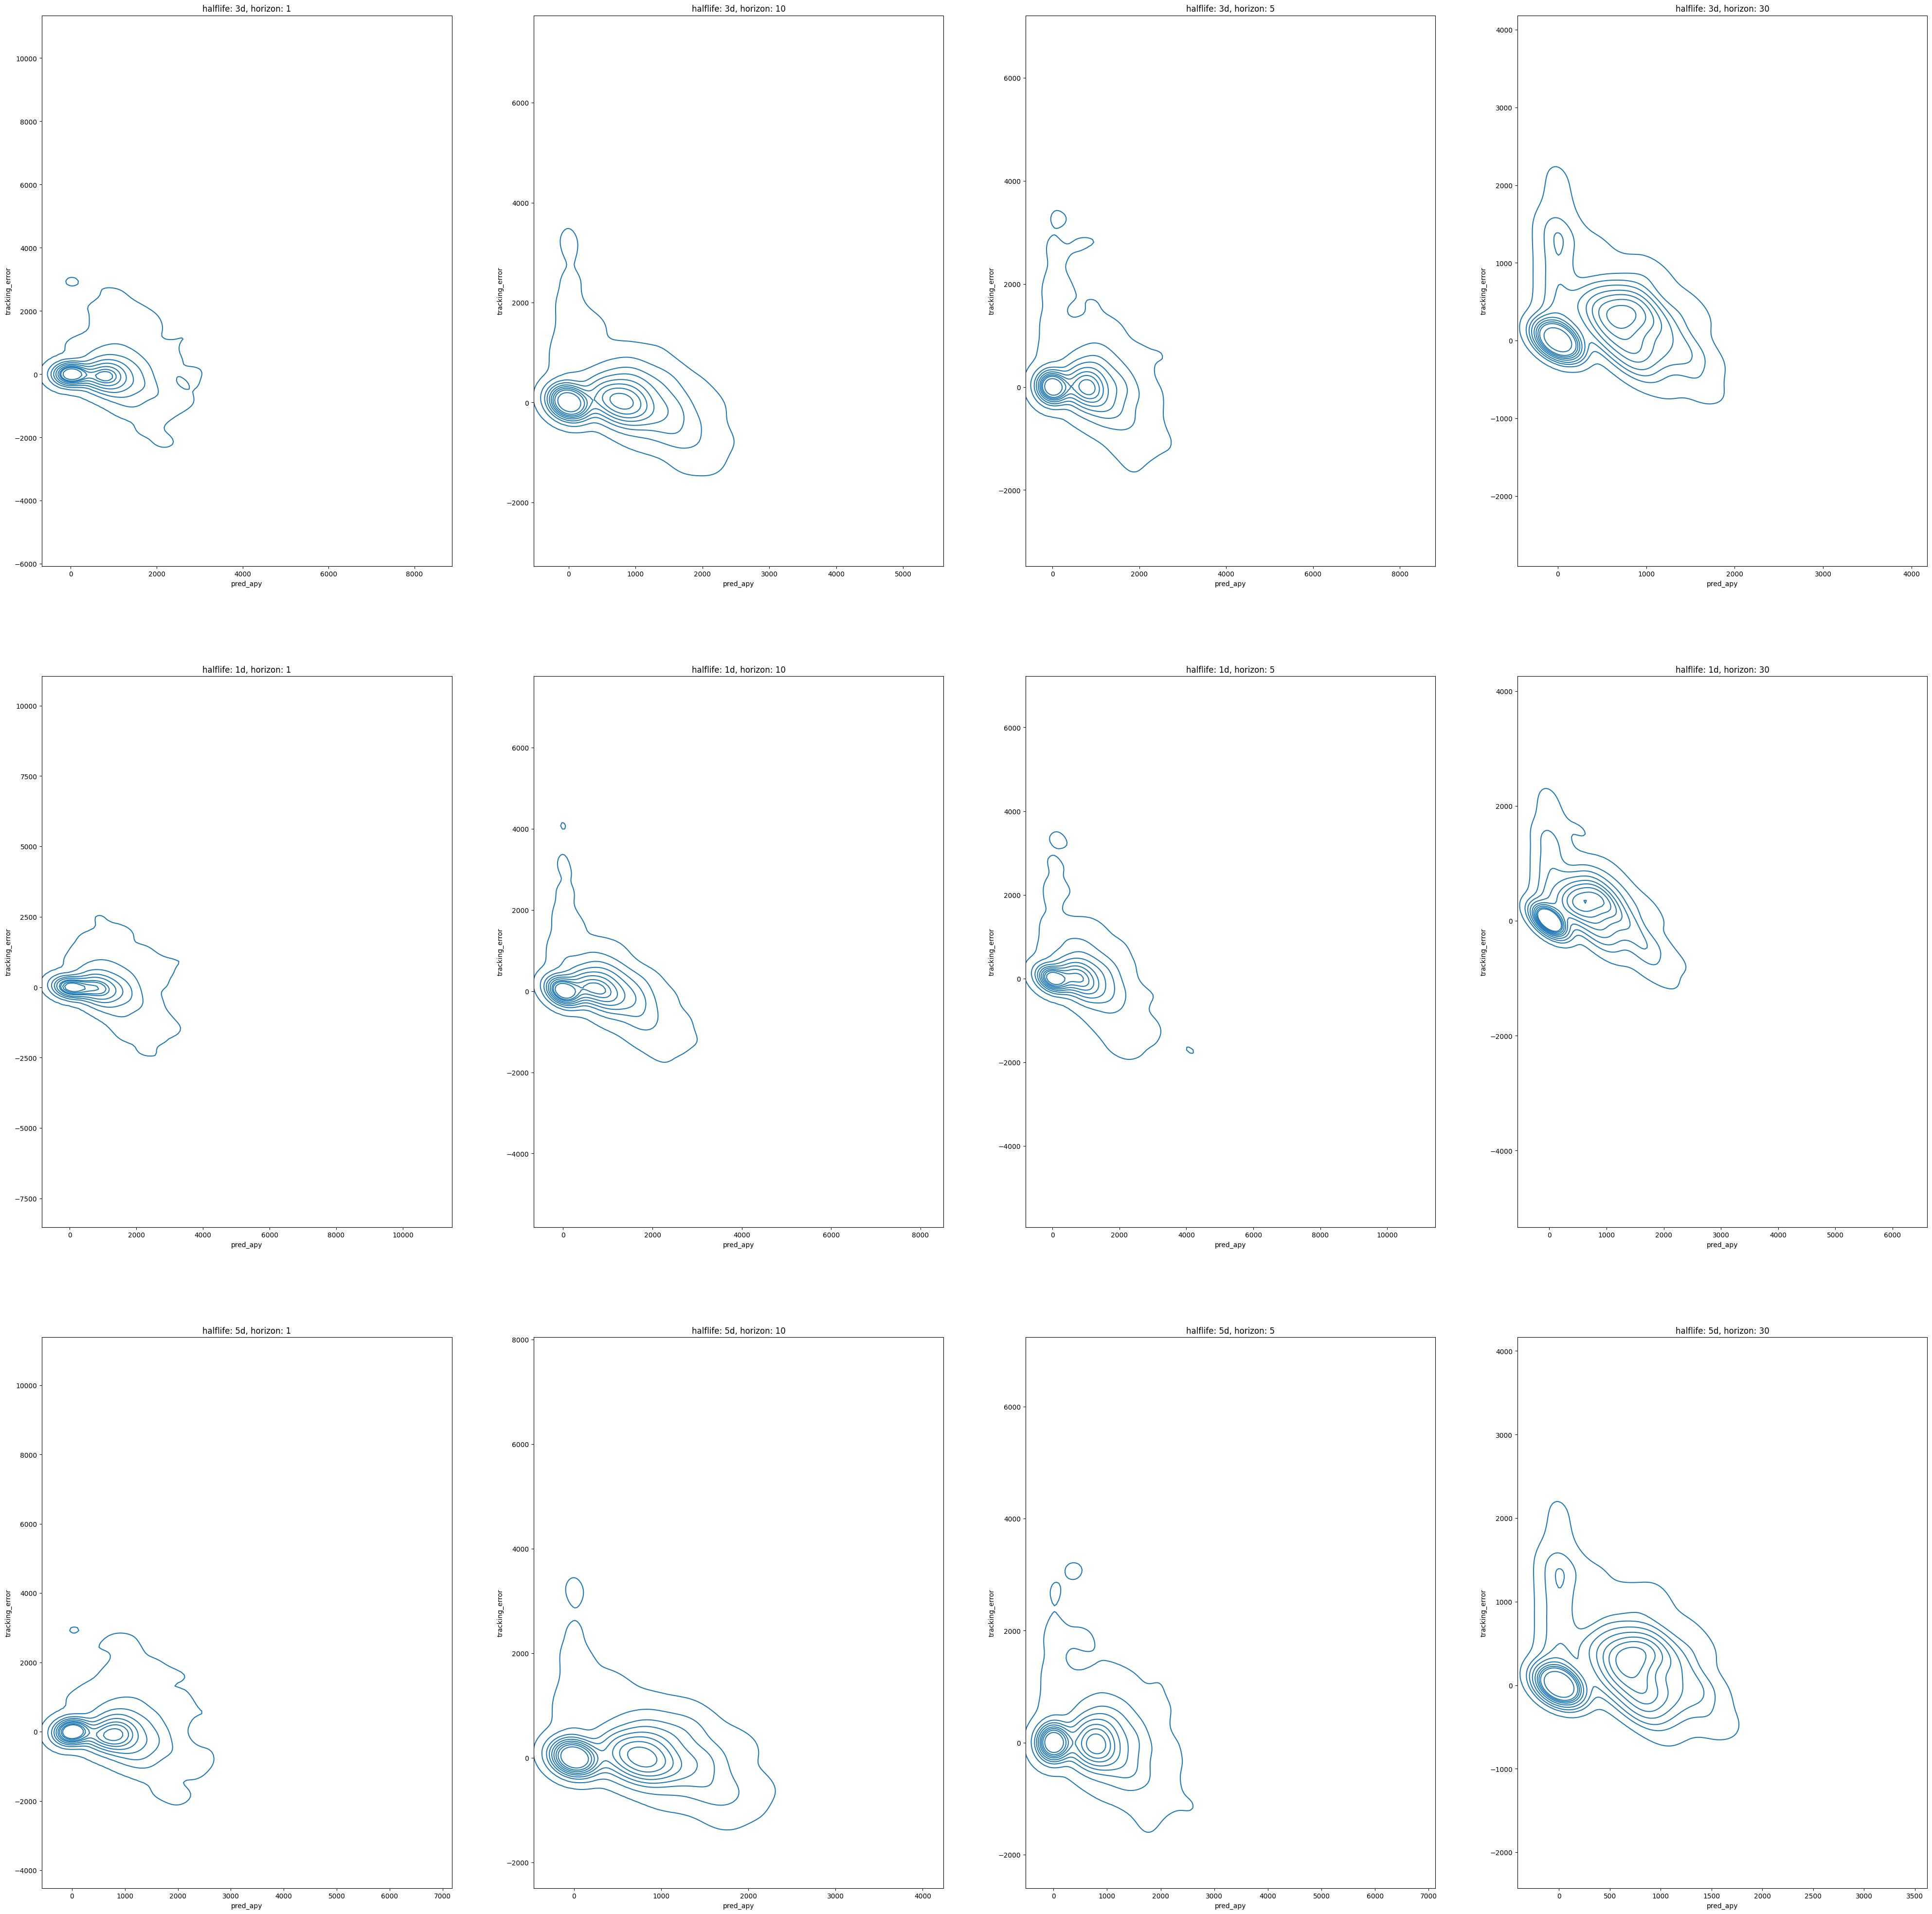

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

rows, cols = list(set(key[0] for key in scatters.keys())), list(set(key[1] for key in scatters.keys()))
nrows=len(rows)
ncols=len(cols)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(50, 50))

tracking_error = {}
apy ={}

# Iterate through the dictionary and plot each density plot in the correct position
for key, df in scatters.items():
    row = rows.index(key[0])
    col = cols.index(key[1])
    title = f'halflife: {key[0]}, horizon: {key[1]}'
    sns.kdeplot(data=df, 
                x='pred_apy', 
                y='tracking_error', 
                ax=axs[row, col], 
#                hue='datetime',
                legend=False).set(title=title)
    tracking_error[key] = df["tracking_error"].describe()
    apy[key] = df["apy"].describe()

plt.show()

# tracking error stats

In [23]:
pd.options.display.float_format = '${:,.0f}'.format
pd.concat({'tracking_error': pd.DataFrame(tracking_error), 'apy': pd.DataFrame(apy)}, axis=0)

1d                              3d                  \
                          1       5       10      30      1       5       10   
tracking_error count  $2,700  $2,580  $2,430  $1,830  $3,150  $3,010  $2,835   
               mean      $11     $45    $108    $224     $53     $91    $144   
               std      $751    $670    $742    $595    $755    $677    $745   
               min   $-7,915 $-5,396 $-5,208 $-4,821 $-5,482 $-2,942 $-2,681   
               25%     $-137   $-110    $-70      $0   $-167   $-102    $-79   
               50%        $0      $0      $0    $165      $0      $0      $0   
               75%       $80    $159    $211    $460     $85    $146    $203   
               max   $10,439  $6,679  $7,153  $3,748 $10,760  $6,679  $7,153   
apy            count  $2,700  $2,580  $2,430  $1,830  $3,150  $3,010  $2,835   
               mean     $910    $875    $794    $650    $875    $843    $760   
               std    $1,173  $1,140    $937    $772  $1,132  $1,103    $907   
               min        $0      $0      $0      $0      $0      $0      $0   
               25%        $0      $0      $0      $0      $0      $0      $0   
               50%      $679    $643    $584    $476    $658    $618    $563   
               75%    $1,195  $1,173  $1,154    $980  $1,165  $1,151  $1,120   
               max   $13,459 $13,459 $11,267 $11,267 $13,459 $13,459 $11,267   

                                  5d                          
                          30      1       5       10      30  
tracking_error count  $2,135  $3,330  $3,182  $2,997  $2,257  
               mean     $246     $81    $116    $158    $250  
               std      $522    $803    $714    $759    $503  
               min   $-2,466 $-3,889 $-2,038 $-1,893 $-2,010  
               25%        $0   $-191   $-126   $-104      $0  
               50%      $140      $0      $0      $0    $120  
               75%      $453    $102    $178    $230    $442  
               max    $3,748 $10,761  $6,679  $7,442  $3,748  
apy            count  $2,135  $3,330  $3,182  $2,997  $2,257  
               mean     $609    $860    $829    $751    $610  
               std      $732  $1,113  $1,084    $896    $732  
               min        $0      $0      $0      $0      $0  
               25%        $0      $0      $0      $0      $0  
               50%      $468    $630    $588    $543    $457  
               75%      $944  $1,143  $1,125  $1,105    $934  
               max   $11,267 $13,459 $13,459 $11,267 $11,267

## scatter version

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

rows, cols = list(set(key[0] for key in scatters.keys())), list(set(key[1] for key in scatters.keys()))
nrows=len(rows)
ncols=len(cols)

fig = make_subplots(
    rows=nrows,
    cols=ncols
)

# Iterate through the dictionary and plot each density plot in the correct position
for i, (key, df) in enumerate(scatters.items()):
    row = (i // ncols)+1
    col = (i % ncols)+1
    sns.kdeplot(data=df, x='pred_apy', y='tracking_error', ax=axs[row, col], hue='pool')
    ax = go.Scatter(x=df['pred_apy'], 
                    y=df['tracking_error'],
                    mode='markers',
                    marker=dict(color=df['datetime'].apply(lambda t: pd.to_datetime(t).timestamp())),
                    hovertext=df['datetime'],
                    text=f'halflife: {key[0]}, horizon: {key[1]}')
    fig.add_trace(ax, row=row, col=col)
    
fig.update_layout(height=2000)
fig.show()

In [ ]:
px.line(apy.rolling(window=10).mean().shift(-10))